In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [15]:
from bellem.dvc.experiment import load_experiments

filenames = [
    "temperature-sweep-1.json",
    "temperature-sweep-2.json",
]

experiments = [exp for filename in filenames for exp in load_experiments(filename)]
print(f"{len(experiments)} experiments")
experiments[0]

289 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'system_prompt': 'no-role.txt',
   'user_prompt_template': 'cq.txt',
   'few_shot_examples': 'empty.json'},
  'run': 1},
 'metrics': {}}

In [54]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])
df = df[df["params.dataset.path"] == "bdsaglam/musique"].copy()
df.drop(columns=[col for col in df.columns if "fuzzy" in col], inplace=True)

param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.dropna(subset=param_cols + metric_cols, inplace=True, how="any")
df.drop_duplicates(subset=param_cols, inplace=True)
df.drop(
    columns=[
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [55]:
def remove_extension(filename):
    return filename.replace(".txt", "")

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_extension)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_extension)

In [56]:
def parse_qa_technique(system_prompt_filename):
    if "cte" in system_prompt_filename:
        return "CTE"
    if "cot" in system_prompt_filename:
        return "COT"
    return "Standard"

df["params.qa.technique"] = df["params.qa.system_prompt"].map(parse_qa_technique)

In [57]:
import re

def parse_n_shot(x):
    if 'empty' in x:
        return 0
    # match the digit in the string
    x = re.search(r'\d+', x).group()
    return int(x)

assert parse_n_shot('empty.json') == 0
assert parse_n_shot('cot-2-shot.json') == 2

In [58]:
df['params.qa.n_shot'] = df['params.qa.few_shot_examples'].map(parse_n_shot)

In [65]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [66]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples", "params.qa.temperature"])[
        "params.run"
    ]
    .aggregate(tuple)
    .reset_index()
)
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run
89,standard/minimal-output-format-fewest,cq,empty.json,0.1,"(1, 3)"


In [67]:
# Filter out experiments with F1 score < 0.1
df_filtered = df[df['metrics.f1'] >= 0.1].copy()
df_filtered.shape

(263, 15)

In [68]:
df_filtered

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,0.0,cot/excellent-format-reasoning,cq,empty.json,1,0.407944,0.489914,0.533546,0.625827,0.311842,0.377059,0.200000,0.281535,COT,0
1,0.0,cot/excellent-format-reasoning,cq,empty.json,2,0.407116,0.492792,0.527955,0.625286,0.310526,0.382631,0.214815,0.289931,COT,0
2,0.0,cot/excellent-format-reasoning,cq,empty.json,3,0.401738,0.489893,0.530351,0.627570,0.301316,0.377814,0.192593,0.274604,COT,0
3,0.1,cot/excellent-format-reasoning,cq,empty.json,1,0.409599,0.493538,0.535144,0.630265,0.306579,0.378292,0.214815,0.287126,COT,0
4,0.1,cot/excellent-format-reasoning,cq,empty.json,2,0.405048,0.490532,0.531949,0.629372,0.307895,0.374431,0.195062,0.279196,COT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,1.5,standard/minimal-output-format-fewest,cq,empty.json,2,0.527513,0.659429,0.585463,0.709983,0.517105,0.666309,0.367901,0.490239,Standard,0
283,1.5,standard/minimal-output-format-fewest,cq,empty.json,3,0.537029,0.661377,0.575080,0.701884,0.548684,0.677860,0.397531,0.505225,Standard,0
284,2.0,standard/minimal-output-format-fewest,cq,empty.json,1,0.271825,0.382596,0.313099,0.421900,0.260526,0.371239,0.165432,0.282405,Standard,0
285,2.0,standard/minimal-output-format-fewest,cq,empty.json,2,0.280099,0.371865,0.321885,0.418983,0.277632,0.375419,0.155556,0.219537,Standard,0


In [71]:
df_filtered['params.qa.system_prompt'].unique()

array(['cot/excellent-format-reasoning', 'cot/format-minimal',
       'cot/format-reasoning', 'cot/format-think',
       'standard/excellent-few', 'standard/excellent-fewest',
       'standard/helpful-output-format-few',
       'standard/minimal-output-format',
       'standard/minimal-output-format-few',
       'standard/minimal-output-format-few-no-prio',
       'standard/minimal-output-format-fewest'], dtype=object)

In [72]:
def prepare_data_for_anova(dataf, technique):
    metric_column='metrics.f1'
    
    # Filter data for the specified technique
    filtered_data = dataf[dataf['params.qa.technique'] == technique]

    if filtered_data.empty:
        raise ValueError(f"No data available for technique: {technique}")

    # Simplify column names for use in formula
    filtered_data = filtered_data.rename(columns={
        'params.qa.temperature': 'temperature',
        'params.qa.system_prompt': 'system_prompt',
        'params.qa.user_prompt_template': 'user_prompt',
    })

    # Combine prompts into a single column for simplicity
    filtered_data['prompt'] = filtered_data['system_prompt'] + ' | ' + filtered_data['user_prompt']

    return filtered_data[['temperature', 'prompt', 'params.run', metric_column]].rename(columns={metric_column: 'f1'})

def two_way_anova(dataf):
    # Perform Two-Way ANOVA with replication
    formula = 'f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)'
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)

def one_way_anova_by_temperature(dataf):
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf['temperature'].unique()
    for temp in temperatures:
        temp_data = dataf[dataf['temperature'] == temp]
        grouped = temp_data.groupby('prompt')['f1'].apply(list).reset_index()
        f1_scores = grouped['f1']

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp}:")
        print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")

def visualize_results(dataf):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='temperature', y='f1', hue='prompt', data=dataf)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    plt.legend(title="Prompt", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

prepared_data = prepare_data_for_anova(df_filtered, technique='Standard')


In [64]:
# Two-Way ANOVA
two_way_anova(prepared_data)

Two-Way ANOVA Results:
                            sum_sq     df             F         PR(>F)
C(prompt)                 0.028838    6.0    473.107195   1.321871e-76
C(temperature)            1.827768    7.0  25702.443154  5.202005e-175
C(prompt):C(temperature)  0.002067   42.0      4.843303   1.528850e-11
Residual                  0.001128  111.0           NaN            NaN


In [43]:
# Perform One-Way ANOVA by Temperature
one_way_anova_by_temperature(prepared_data)

One-Way ANOVA for Temperature 0.0:
F-statistic: 693.3186, p-value: 1.7094e-16
One-Way ANOVA for Temperature 0.1:
F-statistic: 303.7822, p-value: 3.3422e-13
One-Way ANOVA for Temperature 0.3:
F-statistic: 242.9921, p-value: 2.4928e-13
One-Way ANOVA for Temperature 0.5:
F-statistic: 159.1387, p-value: 4.6175e-12
One-Way ANOVA for Temperature 0.7:
F-statistic: 104.6674, p-value: 8.1227e-11
One-Way ANOVA for Temperature 1.0:
F-statistic: 65.8651, p-value: 1.8592e-09
One-Way ANOVA for Temperature 1.5:
F-statistic: 73.3054, p-value: 9.0608e-10
One-Way ANOVA for Temperature 2.0:
F-statistic: 8.8262, p-value: 4.2020e-04


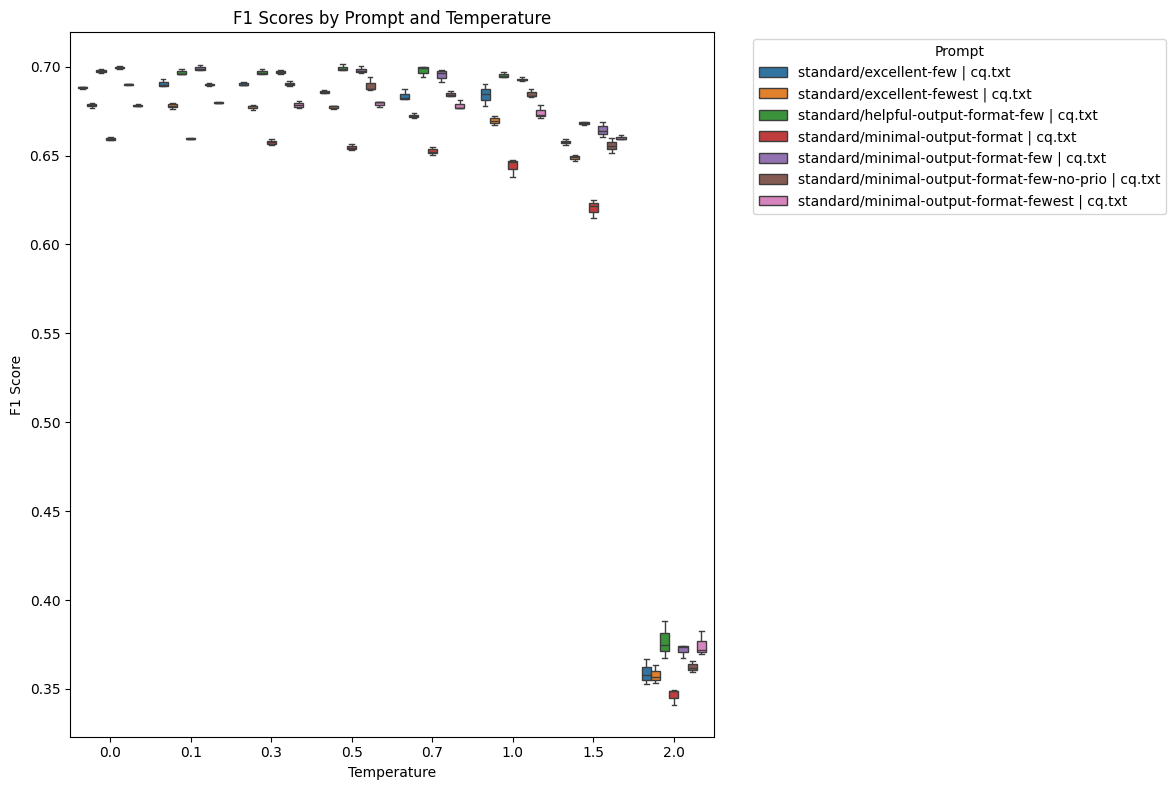

In [44]:

# Visualize Results
visualize_results(prepared_data)
